In [ ]:
# Step 1: Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import joblib

# Step 2: Load combined features and labels
X = np.load('../data/features_combined.npy')
y = pd.read_csv('../data/labels.csv')  # assuming binary classification labels (0 or 1)

# Step 3: Handle missing values (NaNs)
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Step 4: Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Step 6: Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print("📊 Random Forest Results:")
print("Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))

# Save Random Forest model
joblib.dump(rf, "../models/random_forest_model.pkl")




In [ ]:
# Step 7: Train XGBoost
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

print("\n📊 XGBoost Results:")
print("Accuracy:", accuracy_score(y_test, xgb_preds))
print(classification_report(y_test, xgb_preds))

# Save XGBoost model
joblib.dump(xgb, "../models/xgboost_model.pkl")


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, confusion_matrix, 
    ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve
import joblib

# Load the Random Forest model
rf_model = joblib.load('../models/random_forest_model.pkl')

# Load the XGBoost model
xgb_model = joblib.load('../models/xgboost_model.pkl')

# Step 2: Load combined features and labels
X = np.load('../data/features_combined.npy')
y = pd.read_csv('../data/labels.csv')  # assuming binary classification labels (0 or 1)

# Step 3: Handle missing values (NaNs)
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Step 4: Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Generate predictions
rf_probs = rf_model.predict_proba(X_test)[:, 1]
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]



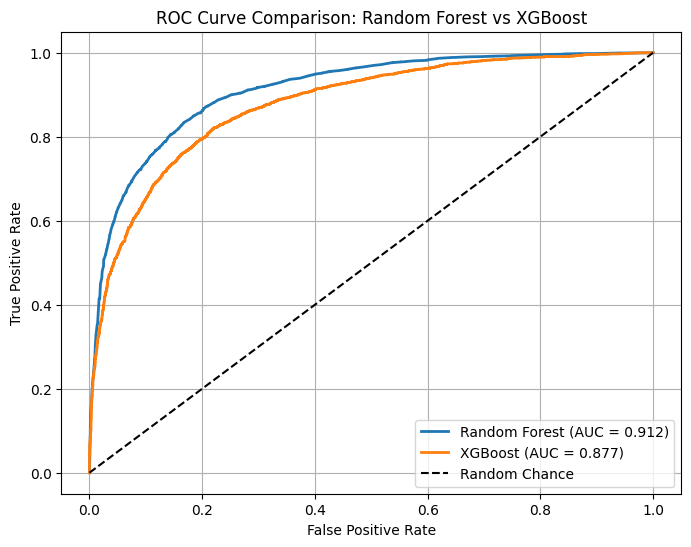

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# 1. ROC Curve Comparison

# Compute ROC curve and AUC for Random Forest
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
rf_auc = roc_auc_score(y_test, rf_probs)

# Compute ROC curve and AUC for XGBoost
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
xgb_auc = roc_auc_score(y_test, xgb_probs)

# Plot both ROC curves on the same figure
plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.3f})', linewidth=2)
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Random Forest vs XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


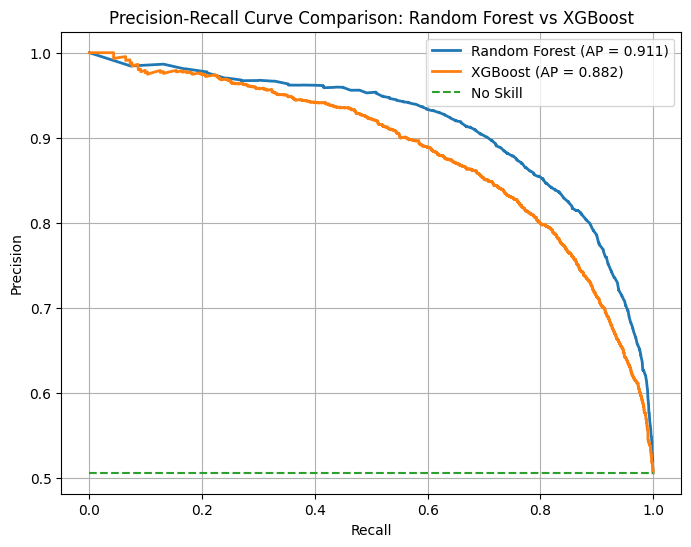

In [10]:
# 2. Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision-recall curve and average precision for Random Forest
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_probs)
rf_ap = average_precision_score(y_test, rf_probs)
# Compute precision-recall curve and average precision for XGBoost
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, xgb_probs)
xgb_ap = average_precision_score(y_test, xgb_probs)

# Plotting both Precision-Recall curves on the same plot
plt.figure(figsize=(8, 6))
plt.plot(rf_recall, rf_precision, label=f'Random Forest (AP = {rf_ap:.3f})', linewidth=2)
plt.plot(xgb_recall, xgb_precision, label=f'XGBoost (AP = {xgb_ap:.3f})', linewidth=2)

# Baseline (no skill) line
y_test_numeric = np.array(y_test).astype(int)
no_skill = sum(y_test_numeric) / len(y_test_numeric)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison: Random Forest vs XGBoost')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


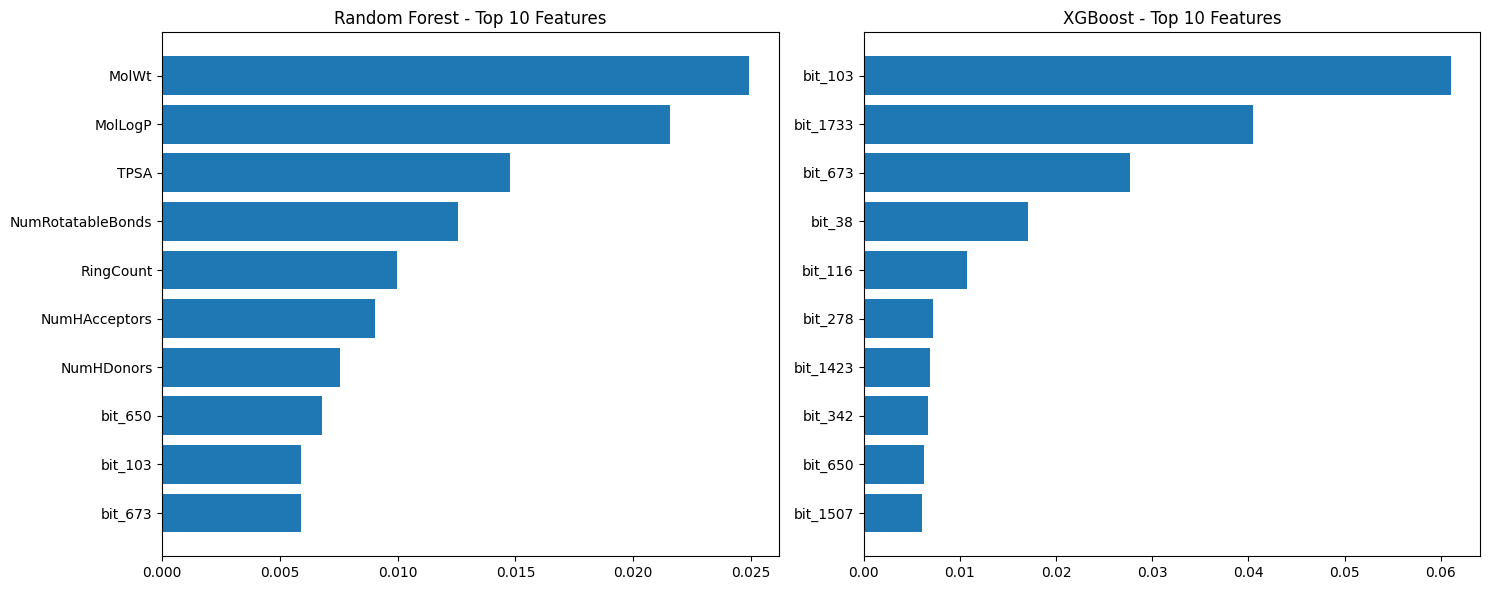

In [13]:
# 3. Feature Importance
fig, ax = plt.subplots(1, 2, figsize=(15,6))
# Load feature names from CSV header
df = pd.read_csv('../data/features_combined.csv')
feature_names = df.columns.tolist()
X = pd.DataFrame(X, columns=feature_names)

# Random Forest Feature Importance
rf_importance = rf_model.feature_importances_
sorted_idx = rf_importance.argsort()
ax[0].barh(range(10), rf_importance[sorted_idx][-10:])
ax[0].set_yticks(range(10))
ax[0].set_yticklabels(X.columns[sorted_idx][-10:])
ax[0].set_title('Random Forest - Top 10 Features')

# XGBoost Feature Importance
xgb_importance = xgb_model.feature_importances_
sorted_idx = xgb_importance.argsort()
ax[1].barh(range(10), xgb_importance[sorted_idx][-10:])
ax[1].set_yticks(range(10))
ax[1].set_yticklabels(X.columns[sorted_idx][-10:])
ax[1].set_title('XGBoost - Top 10 Features')
plt.tight_layout()
plt.show()


In [ ]:

print("Calculating permutation importance...")
rf_result = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42)
xgb_result = permutation_importance(xgb_model, X_test, y_test, n_repeats=10, random_state=42)

fig, ax = plt.subplots(1, 2, figsize=(15,6))
sorted_idx = rf_result.importances_mean.argsort()
ax[0].boxplot(rf_result.importances[sorted_idx][-10:].T, vert=False,
             labels=X.columns[sorted_idx][-10:])
ax[0].set_title("Random Forest Permutation Importance")

sorted_idx = xgb_result.importances_mean.argsort()
ax[1].boxplot(xgb_result.importances[sorted_idx][-10:].T, vert=False,
             labels=X.columns[sorted_idx][-10:])
ax[1].set_title("XGBoost Permutation Importance")
plt.tight_layout()
plt.show()

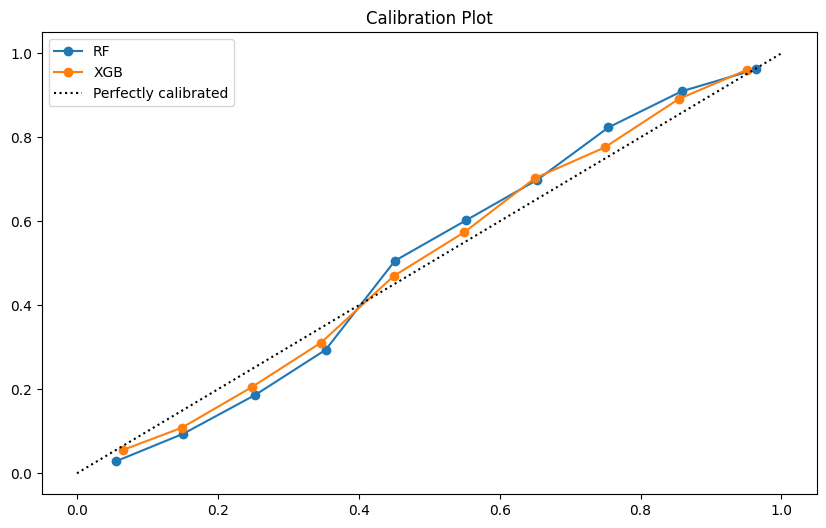

In [ ]:
# 5. Calibration Plots

import matplotlib.pyplot as plt


plt.figure(figsize=(10,6))
for name, probs in [('RF', rf_probs), ('XGB', xgb_probs)]:
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, probs, n_bins=10)
    plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label=name)
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
plt.title('Calibration Plot')
plt.legend()
plt.show()

C:\Users\shadr\AppData\Local\Temp\ipykernel_20568\2707554471.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[0].boxplot(rf_result.importances[top_features_idx][sorted_idx][-10:].T,
C:\Users\shadr\AppData\Local\Temp\ipykernel_20568\2707554471.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[1].boxplot(xgb_result.importances[sorted_idx_xgb][-10:].T,


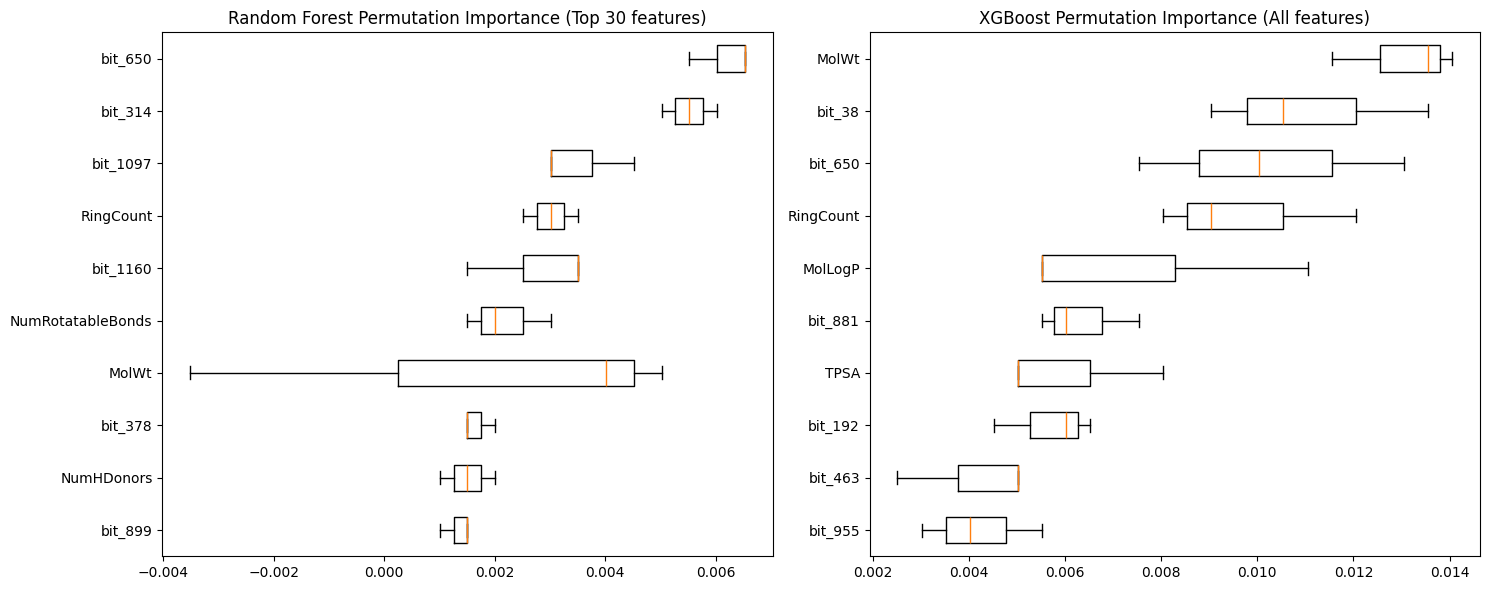

In [ ]:

# 4. Permutation Importance (More reliable)

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt

# Subsample test data (30%)
X_test_sub, _, y_test_sub, _ = train_test_split(
    X_test, y_test, test_size=0.7, random_state=42, stratify=y_test
)

# Calculate permutation importance on full feature set (all 2055 features)
rf_result = permutation_importance(
    rf_model, X_test_sub, y_test_sub,
    n_repeats=3, random_state=42, n_jobs=-1
)

xgb_result = permutation_importance(
    xgb_model, X_test_sub, y_test_sub,
    n_repeats=3, random_state=42, n_jobs=-1
)


# Load feature names from CSV header
df = pd.read_csv('../data/features_combined.csv')
feature_names = df.columns.tolist()
X = pd.DataFrame(X, columns=feature_names)


# Get top 30 features by RF built-in importance
top_features_idx = np.argsort(rf_model.feature_importances_)[-30:]
top_features_names = np.array(feature_names)[top_features_idx]

##top_features_names = X.columns[top_features_idx]

# Select top 30 features from permutation importance results
# Sort permutation importance means for top 30 features
sorted_idx = np.argsort(rf_result.importances_mean[top_features_idx])

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot RF permutation importance for top 10 of top 30 features
ax[0].boxplot(rf_result.importances[top_features_idx][sorted_idx][-10:].T,
              vert=False,
              labels=top_features_names[sorted_idx][-10:])
ax[0].set_title("Random Forest Permutation Importance (Top 30 features)")

# Plot XGBoost permutation importance (top 10 features overall)
sorted_idx_xgb = xgb_result.importances_mean.argsort()
ax[1].boxplot(xgb_result.importances[sorted_idx_xgb][-10:].T,
              vert=False,
              labels=X.columns[sorted_idx_xgb][-10:])
ax[1].set_title("XGBoost Permutation Importance (All features)")

plt.tight_layout()
plt.show()
